### Importin the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from helpers import undersampling
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

### Preprocessing

In [2]:
df = pd.read_csv('data_set.csv')
df = undersampling(df,['water', 'forest', 'fields', 'other'],0.1)
X = df.iloc[:,1:14].to_numpy()
Y = df.iloc[:,-4:].to_numpy()

Train/test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

Feature scaling
$$x = \frac{\overline{x} - x}{\sigma_{x}}$$

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

 Dimensionlity reduction

In [5]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

TO DO Cross Validation

# Unsupervised classification with SOM

In [6]:
def IoU(target, predicted):
    """return intersection over union"""
    iou = np.sum(np.logical_and(target,predicted))
    iou = iou / (np.sum(np.logical_or(target,predicted)) + 1e-10)
    return iou

In [7]:
def metrics_matrix(Y_target, Y_pred, metric=IoU):
    """Compare target classes with predicted classes. 
    Return matrix with metrics
    """
    matrix = np.zeros((Y_pred.shape[1],Y_target.shape[1]))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):    
            matrix[i][j] = IoU(Y_target[:,j],Y_pred[:,i])
    return matrix

### Preprocessing

In [8]:
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

### Training

In [9]:
from minisom import MiniSom
x_som, y_som = 4,4
som = MiniSom(x=x_som, y=y_som, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, num_iteration=100000, verbose=False)

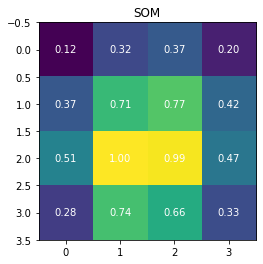

In [10]:
#ax.colorbar()
fig, ax = plt.subplots()
ax.set_title('SOM')
plt.imshow(som.distance_map())
for (i, j), z in np.ndenumerate(som.distance_map()):
    if z > 0.10:
        ax.text(j, i, '{:0.2f}'.format(som.distance_map()[i,j]), ha='center', va='center',color = 'white')

### Predictions

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_pred = [som.winner(x) for x in X]
y_pred = np.array([i[0]*100 + i[1] for i in y_pred ])
y_pred = enc.fit_transform(y_pred.reshape(-1, 1)).toarray()

### Evaluation

In [12]:
cm = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))

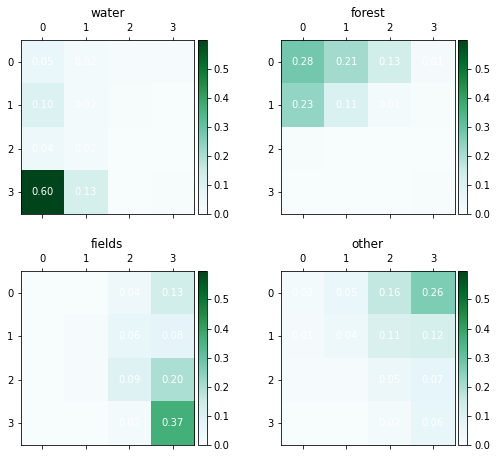

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(figsize=(8,6), ncols = 2, nrows=2)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.4)
vmax = np.max(cm)/(0.25*len(y_pred))
for i, ax in enumerate(axs.flatten()):
    data = cm[i,:].reshape((x_som,y_som))/(0.25*len(y_pred))
    subplot = ax.matshow(data,vmin=0, vmax=vmax, cmap='BuGn')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title(df.columns[-4+i])
    for (i, j), z in np.ndenumerate(data):
        if(z>0.01):
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',color = 'white')
    fig.colorbar(subplot, cax=cax)

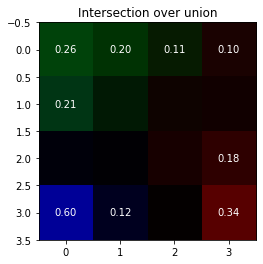

In [14]:
clusstered = np.zeros((x_som,y_som,3))
metrix_IoU = metrics_matrix(y, y_pred, IoU)
clusstered[...,2]=metrix_IoU[:,0].reshape((x_som,y_som))
clusstered[...,1]=metrix_IoU[:,1].reshape((x_som,y_som))
clusstered[...,0]=metrix_IoU[:,2].reshape((x_som,y_som))
fig, ax = plt.subplots()
ax.set_title('Intersection over union')
plt.imshow(clusstered)
for (i, j, k), z in np.ndenumerate(clusstered):
    if z > 0.10:
        ax.text(j, i, '{:0.2f}'.format(max(clusstered[i,j,:])), ha='center', va='center',color = 'white')


In [16]:
best_3 = [metrix_IoU[:,i].argsort()[-3:][::-1] for i in range(3)]

X = pd.read_csv('data_set.csv').iloc[:,1:14].to_numpy()
X = sc.fit_transform(X)
X = pca.transform(X)

enc = OneHotEncoder()
y_pred = [som.winner(x) for x in X]
y_pred = np.array([i[0]*100 + i[1] for i in y_pred ])
y_pred = enc.fit_transform(y_pred.reshape(-1, 1)).toarray()

IndexError: list index out of range

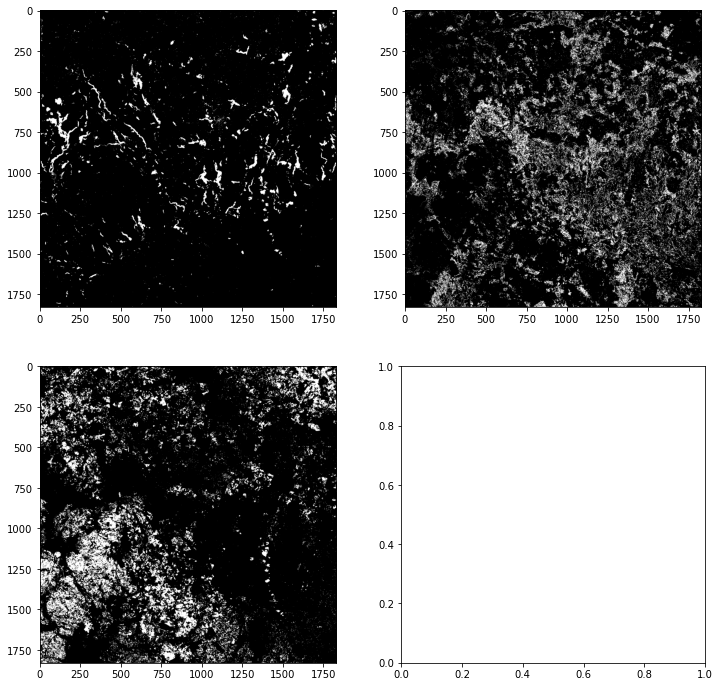

In [17]:
Y_present = y_pred.reshape((1830,1830,y_pred.shape[1]))
fig, axs = plt.subplots(figsize=(12,12), ncols = 2, nrows=2)
axs[0,0].imshow(Y_present[...,best_3[0][0]]*255+Y_present[...,best_3[0][1]]*255,cmap='gray', vmin=0, vmax=255)
axs[0,1].imshow(Y_present[...,best_3[1][0]]*255+Y_present[...,best_3[1][1]]*255,cmap='gray', vmin=0, vmax=255)
axs[1,0].imshow(Y_present[...,best_3[2][0]]*255+Y_present[...,best_3[2][1]]*255,cmap='gray', vmin=0, vmax=255)
axs[1,1].imshow(Y_present[...,best_3[3][0]]*255+Y_present[...,best_3[3][1]]*255,cmap='gray', vmin=0, vmax=255)